# Chapter 11 How to Develop Simple Methods for Univariate Forecasting

In this tutorial, you will discover how to develop a framework from scratch for grid searching simple naive and averaging strategies for time series forecasting with univariate data. After completing this tutorial, you will know:
- How to develop a framework for grid searching simple models from scratch using walk- forward validation.
- How to grid search simple model hyperparameters for daily time series data for births.
- How to grid search simple model hyperparameters for monthly time series data for shampoo sales, car sales, and temperature.

This tutorial is divided into six parts; they are:
1. Simple Forecasting Strategies
2. Develop a Grid Search Framework
3. Case Study 1: No Trend or Seasonality
4. Case Study 2: Trend
5. Case Study 3: Seasonality
6. Case Study 4: Trend and Seasonality

## 11.2 Simple Forecasting Strategies

There are two main themes to simple forecast strategies; they are:
- Naive, or using observations values directly.
- Average, or using a statistic calculated on previous observations.


## 11.3 Develop a Grid Search Framework

For a given dataset of historical observations, we can persist any value in that history, that is from the previous observation at index -1 to the first observation in the history at -(len(data)). The naive forecast() function below implements the naive forecast strategy for a given offset from 1 to the length of the dataset.

在本节中，我们将开发一个网格搜索框架，用于搜索上一节中描述的两种简单预测策略，即朴素策略和平均策略。我们可以从实施幼稚的预测策略开始。对于给定的历史观测数据集，我们可以保留该历史中的任何值，即从索引 -1 处的先前观测到历史中的第一个观测值 -（len（data））。下面的朴素 forecast（） 函数实现了从 1 到数据集长度的给定偏移量的朴素预测策略。


### 11.3.1 naive forecast

- 使用往前递推作为预报结果

In [3]:
# example of a one-step naive forecast
def naive_forecast(history, n):
    return history[-n]
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
    print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


### 11.3.2 mean forecast

- 使用往前递推的平均值作为预报结果

In [5]:
# example of an average forecast
from numpy import mean
from numpy import median
# one-step average forecast
def average_forecast(history, config):
    n, avg_type = config
    # mean of last n values
    if avg_type is 'mean':
        return mean(history[-n:])
    # median of last n values
    return median(history[-n:])
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
    print(average_forecast(data, (i, 'mean')))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0


<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-5e3e24c4170e>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if avg_type is 'mean':


- 分别使用1，2，3个季度的平均值作为预测结果

In [17]:
# example of an average forecast for seasonal data
from numpy import mean
from numpy import median
# one-step average forecast
def average_forecast(history, config):
    n, offset, avg_type = config
    values = list()
    if offset == 1:# 表示每个季度只有一个数
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            print('-ix:',-ix)
            values.append(history[-ix])
        # mean of last n values
    if avg_type == 'mean': 
        return mean(values)
    # median of last n values
    return median(values)
    # define dataset
data = [10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
print(data)
# test naive forecast
for i in [1, 2, 3]:# 分别使用1，2，3个季度的平均值作为预测结果
    print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
-ix: -3
10.0
-ix: -3
-ix: -6
10.0
-ix: -3
-ix: -6
-ix: -9
10.0


- grid search method

In [21]:
#pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

# 单步简单预报
# one-step simple forecast
def simple_forecast(history, config): 
    n, offset, avg_type = config
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
      # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean':
        return mean(values)
    # median of last n values
    return median(values)

# 计算均方根误差
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# 拆分训练集和测试集
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# 调用simple_forecast方法进行前向验证
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# 异常处理
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# 网格搜索的配置
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # 配置并行程序
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]# 去除空的结果
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# 创建配置tuple
# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs


if __name__ == '__main__':
    # define dataset
    data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0] # data split
    n_test = 4
    # model configs
    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length)
    print(cfg_list)
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

[[1, 1, 'persist'], [1, 1, 'mean'], [1, 1, 'median'], [2, 1, 'persist'], [2, 1, 'mean'], [2, 1, 'median'], [3, 1, 'persist'], [3, 1, 'mean'], [3, 1, 'median'], [4, 1, 'persist'], [4, 1, 'mean'], [4, 1, 'median']]


## 11.4 Case Study 1: No Trend or Seasonality

(365, 1)


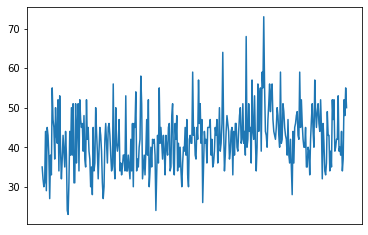

In [5]:
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('daily-total-female-births.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [ ]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv
# one-step simple forecast
def simple_forecast(history, config): 
    n, offset, avg_type = config
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean': 
        return mean(values)
    # median of last n values
    return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
      # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

if __name__ == '__main__':
    # define dataset
    series = read_csv('daily-total-female-births.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 165
    # model configs
    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length)
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

## 11.5 Case Study 2: Trend

- The monthly shampoo sales dataset summarizes the monthly sales of shampoo over a three-year period.

(36, 1)


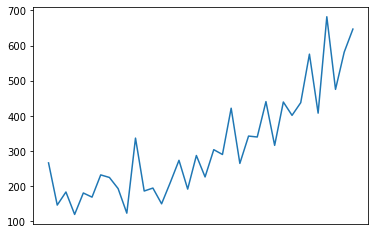

In [1]:
# load and plot monthly shampoo sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [ ]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv
# one-step simple forecast
def simple_forecast(history, config): 
    n, offset, avg_type = config
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean': 
        return mean(values)
    # median of last n values
    return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
      # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

if __name__ == '__main__':
    # load dataset
    series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length)
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

## 11.6 Case Study 3: Seasonality

(240, 1)


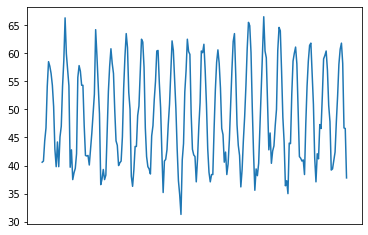

In [2]:
# load and plot monthly mean temp dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [ ]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv
# one-step simple forecast
def simple_forecast(history, config): 
    n, offset, avg_type = config
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean': 
        return mean(values)
    # median of last n values
    return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
      # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
    data = series.values
    # data split
    n_test = 12
    # model configs
    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length, offsets=[1,12]) # grid search
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

## 11.7 Case Study 4: Trend and Seasonality

(108, 1)


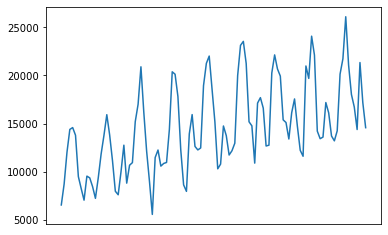

In [1]:
# load and plot monthly car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [ ]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv
# one-step simple forecast
def simple_forecast(history, config): 
    n, offset, avg_type = config
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
    # collect values to average
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        # try and collect n values using offset
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean': 
        return mean(values)
    # median of last n values
    return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# split a univariate dataset into train/test sets

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
      # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs


if __name__ == '__main__':
    # define dataset
    series = read_csv('monthly-car-sales.csv', header=0, index_col=0) 
    data = series.values
    # data split
    n_test = 12
    # model configs
    max_length = len(data) - n_test
    cfg_list = simple_configs(max_length, offsets=[1,12])
    # grid search
    scores = grid_search(data, cfg_list, n_test) 
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)